# Liver & Tumor Segmentation - Cascaded U-Net

This notebook implements a two-stage cascaded approach for liver and tumor segmentation from CT scans using the Medical Segmentation Decathlon Task03_Liver dataset.

**Architecture:**
1. Stage 1: Liver segmentation U-Net
2. Stage 2: Tumor segmentation U-Net (conditioned on liver mask)

In [9]:
# =============================================================================
# IMPORTS (consolidated - no duplicates)
# =============================================================================
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from monai.data import CacheDataset, Dataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscrete,
    Compose,
    CopyItemsd,
    CropForegroundd,
    EnsureChannelFirstd,
    EnsureTyped,
    Lambdad,
    LoadImaged,
    MaskIntensityd,
    Orientationd,
    RandCropByLabelClassesd,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadd,
)
from monai.utils import set_determinism

# Set seeds for reproducibility
set_determinism(42)
torch.set_float32_matmul_precision("medium")

## Configuration

In [10]:
# =============================================================================
# CONFIGURATION
# =============================================================================
ROOT = Path("data/Task03_Liver")
IMAGES_TR = ROOT / "imagesTr"
LABELS_TR = ROOT / "labelsTr"
IMAGES_TS = ROOT / "imagesTs"

# Model hyperparameters
ROI_LIVER = (48, 48, 32)
ROI_TUMOR = (64, 64, 32)
PIXDIM = (1.5, 1.5, 2.0)
HU_MIN, HU_MAX = -200, 200

# Training hyperparameters
BATCH_SIZE = 1
NUM_WORKERS = 4
VAL_FRAC = 0.2
SEED = 42
CACHE_RATE = 0.1
LEARNING_RATE = 1e-4
MAX_EPOCHS = 200
SW_BATCH_SIZE = 2

## Data Loading & Splitting

In [11]:
# =============================================================================
# DATA UTILITIES
# =============================================================================
def list_nii(folder: Path) -> list[Path]:
    """List all valid NIfTI files in a folder, excluding macOS hidden files."""
    return sorted(
        p for p in folder.glob("*.nii.gz")
        if p.is_file() and not p.name.startswith("._")
    )


def split_train_val(files: list, val_frac: float = 0.2, seed: int = 42) -> tuple[list, list]:
    """Split files into train and validation sets."""
    rng = np.random.default_rng(seed)
    idx = np.arange(len(files))
    rng.shuffle(idx)
    
    n_val = int(len(files) * val_frac)
    val_idx, tr_idx = idx[:n_val], idx[n_val:]
    
    return [files[i] for i in tr_idx], [files[i] for i in val_idx]


# Build file lists
train_imgs = list_nii(IMAGES_TR)
test_imgs = list_nii(IMAGES_TS)

train_files = [{"image": str(p), "label": str(LABELS_TR / p.name)} for p in train_imgs]
test_files = [{"image": str(p)} for p in test_imgs]

print(f"Total: {len(train_files)} train+val, {len(test_files)} test")

Total: 131 train+val, 70 test


## Transforms

In [12]:
# =============================================================================
# TRANSFORM PIPELINES
# =============================================================================

def get_common_transforms(keys: list[str], include_label: bool = True) -> list:
    """Get common preprocessing transforms shared across all pipelines."""
    return [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        Orientationd(keys=keys, axcodes="RAS"),
        Spacingd(
            keys=keys,
            pixdim=PIXDIM,
            mode=("bilinear", "nearest") if include_label else ("bilinear",)
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=HU_MIN, a_max=HU_MAX,
            b_min=0.0, b_max=1.0,
            clip=True
        ),
    ]


def get_augmentation_transforms(keys: list[str]) -> list:
    """Get data augmentation transforms for training."""
    return [
        RandFlipd(keys=keys, prob=0.5, spatial_axis=0),
        RandFlipd(keys=keys, prob=0.5, spatial_axis=1),
        RandFlipd(keys=keys, prob=0.5, spatial_axis=2),
        RandRotate90d(keys=keys, prob=0.2, max_k=3),
        RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.3),
    ]


# --- Liver Segmentation Transforms ---
liver_train_tf = Compose([
    *get_common_transforms(["image", "label"]),
    Lambdad(keys=["label"], func=lambda x: (x > 0).astype(x.dtype)),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    SpatialPadd(keys=["image", "label"], spatial_size=ROI_LIVER),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=ROI_LIVER,
        num_samples=4,
        num_classes=2,
        ratios=[0.2, 0.8],
        warn=False,
    ),
    *get_augmentation_transforms(["image", "label"]),
    EnsureTyped(keys=["image", "label"], dtype=(torch.float32, torch.int64)),
])

liver_val_tf = Compose([
    *get_common_transforms(["image", "label"]),
    Lambdad(keys=["label"], func=lambda x: (x > 0).astype(x.dtype)),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    SpatialPadd(keys=["image", "label"], spatial_size=ROI_LIVER),
    EnsureTyped(keys=["image", "label"], dtype=(torch.float32, torch.int64)),
])

liver_test_tf = Compose([
    *get_common_transforms(["image"], include_label=False),
    CropForegroundd(keys=["image"], source_key="image"),
    SpatialPadd(keys=["image"], spatial_size=ROI_LIVER),
    EnsureTyped(keys=["image"], dtype=torch.float32),
])


# --- Tumor Segmentation Transforms ---
tumor_train_tf = Compose([
    *get_common_transforms(["image", "label"]),
    CopyItemsd(keys=["label"], times=1, names=["liver"]),
    Lambdad(keys=["liver"], func=lambda x: (x > 0).astype(x.dtype)),
    Lambdad(keys=["label"], func=lambda x: (x == 2).astype(x.dtype)),
    CropForegroundd(keys=["image", "label", "liver"], source_key="liver"),
    MaskIntensityd(keys=["image"], mask_key="liver"),
    SpatialPadd(keys=["image", "label"], spatial_size=ROI_TUMOR),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=ROI_TUMOR,
        num_samples=6,
        num_classes=2,
        ratios=[0.3, 0.7],
        warn=False,
    ),
    *get_augmentation_transforms(["image", "label"]),
    EnsureTyped(keys=["image", "label"], dtype=(torch.float32, torch.int64)),
])

tumor_val_tf = Compose([
    *get_common_transforms(["image", "label"]),
    CopyItemsd(keys=["label"], times=1, names=["liver"]),
    Lambdad(keys=["liver"], func=lambda x: (x > 0).astype(x.dtype)),
    Lambdad(keys=["label"], func=lambda x: (x == 2).astype(x.dtype)),
    CropForegroundd(keys=["image", "label", "liver"], source_key="liver"),
    MaskIntensityd(keys=["image"], mask_key="liver"),
    SpatialPadd(keys=["image", "label"], spatial_size=ROI_TUMOR),
    EnsureTyped(keys=["image", "label"], dtype=(torch.float32, torch.int64)),
])

/home/bankab/.virtualenvs/GSN_PY39/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


## Data Module

In [13]:
# =============================================================================
# DATA MODULE
# =============================================================================

class SegmentationDataModule(pl.LightningDataModule):
    """Unified data module for segmentation tasks."""
    
    def __init__(
        self,
        train_files: list,
        train_tf,
        val_tf,
        test_files = None,
        test_tf=None,
        batch_size: int = 1,
        num_workers: int = 4,
        val_frac: float = 0.2,
        seed: int = 42,
        cache_rate_train: float = 0.1,
    ):
        super().__init__()
        self.train_files = train_files
        self.test_files = test_files or []
        self.train_tf = train_tf
        self.val_tf = val_tf
        self.test_tf = test_tf
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_frac = val_frac
        self.seed = seed
        self.cache_rate_train = cache_rate_train
        self.train_ds = None
        self.val_ds = None
        self.test_ds = None

    def setup(self, stage = None):
        tr_files, val_files = split_train_val(self.train_files, self.val_frac, self.seed)
        
        self.train_ds = CacheDataset(
            tr_files,
            transform=self.train_tf,
            cache_rate=self.cache_rate_train,
            num_workers=0,
        )
        self.val_ds = Dataset(val_files, transform=self.val_tf)
        
        if self.test_files and self.test_tf:
            self.test_ds = Dataset(self.test_files, transform=self.test_tf)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds, batch_size=self.batch_size, shuffle=True,
            num_workers=self.num_workers, pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds, batch_size=1, shuffle=False,
            num_workers=max(0, self.num_workers // 2), pin_memory=True,
        )

    def test_dataloader(self):
        if self.test_ds is None:
            return None
        return DataLoader(
            self.test_ds, batch_size=1, shuffle=False,
            num_workers=max(0, self.num_workers // 2), pin_memory=True,
        )

## Model Architecture

In [14]:
# =============================================================================
# MODEL ARCHITECTURE
# =============================================================================

def build_unet(
    in_channels: int = 1,
    out_channels: int = 2,
    channels: tuple = (16, 32, 64, 128, 256),
    strides: tuple = (2, 2, 2, 2),
) -> UNet:
    """Build a 3D U-Net with instance normalization."""
    return UNet(
        spatial_dims=3,
        in_channels=in_channels,
        out_channels=out_channels,
        channels=channels,
        strides=strides,
        num_res_units=2,
        norm="INSTANCE",
    )


def build_unet_liver() -> UNet:
    """Build U-Net for liver segmentation (larger network)."""
    return build_unet(channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2))


def build_unet_tumor(in_channels: int = 1) -> UNet:
    """Build U-Net for tumor segmentation (smaller network)."""
    return build_unet(in_channels=in_channels, channels=(16, 32, 64, 128), strides=(2, 2, 2))


class LiverTumorCascade(nn.Module):
    """Cascaded model: liver segmentation -> tumor segmentation."""
    
    def __init__(
        self,
        liver_net: nn.Module,
        tumor_net: nn.Module,
        mode: str = "mask",
        liver_class_idx: int = 1,
        threshold = None,
        freeze_liver: bool = True,
        detach_liver: bool = True,
    ):
        super().__init__()
        if mode not in ("mask", "concat"):
            raise ValueError(f"mode must be 'mask' or 'concat', got '{mode}'")
        
        self.liver_net = liver_net
        self.tumor_net = tumor_net
        self.mode = mode
        self.liver_class_idx = liver_class_idx
        self.threshold = threshold
        self.freeze_liver = freeze_liver
        self.detach_liver = detach_liver
        
        if freeze_liver:
            for param in self.liver_net.parameters():
                param.requires_grad = False

    def forward(self, x: torch.Tensor) -> dict[str, torch.Tensor]:
        # Stage 1: Liver segmentation
        if self.freeze_liver:
            self.liver_net.eval()
            with torch.no_grad():
                liver_logits = self.liver_net(x)
        else:
            liver_logits = self.liver_net(x)
        
        liver_prob = F.softmax(liver_logits, dim=1)[:, self.liver_class_idx : self.liver_class_idx + 1]
        
        if self.threshold is not None:
            liver_mask = (liver_prob > self.threshold).to(liver_prob.dtype)
        else:
            liver_mask = liver_prob
        
        if self.detach_liver:
            liver_mask = liver_mask.detach()
        
        # Stage 2: Tumor segmentation
        tumor_in = x * liver_mask if self.mode == "mask" else torch.cat([x, liver_mask], dim=1)
        tumor_logits = self.tumor_net(tumor_in)
        
        return {
            "liver_logits": liver_logits,
            "liver_mask": liver_mask,
            "tumor_logits": tumor_logits,
            "tumor_in": tumor_in,
        }

## PyTorch Lightning Modules

In [15]:
# =============================================================================
# PYTORCH LIGHTNING MODULES
# =============================================================================

class BaseSegmentationModule(pl.LightningModule):
    """Base Lightning module for segmentation tasks."""
    
    def __init__(self, lr: float = 1e-4, roi_size: tuple = (64, 64, 32), sw_batch_size: int = 2, num_classes: int = 2):
        super().__init__()
        self.save_hyperparameters(ignore=["net", "cascade"])
        self.lr = lr
        self.roi_size = roi_size
        self.sw_batch_size = sw_batch_size
        
        self.loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
        self.dice_metric = DiceMetric(include_background=False, reduction="mean_batch")
        self.post_pred = AsDiscrete(argmax=True, to_onehot=num_classes)
        self.post_label = AsDiscrete(to_onehot=num_classes)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)


class LiverSegmentationModule(BaseSegmentationModule):
    """Lightning module for liver-only segmentation."""
    
    def __init__(self, net: nn.Module, **kwargs):
        super().__init__(**kwargs)
        self.net = net

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        logits = self.net(batch["image"])
        loss = self.loss_fn(logits, batch["label"])
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = sliding_window_inference(batch["image"], self.roi_size, self.sw_batch_size, self.net)
        preds = [self.post_pred(p) for p in decollate_batch(logits)]
        labels = [self.post_label(l) for l in decollate_batch(batch["label"])]
        self.dice_metric(preds, labels)

    def on_validation_epoch_end(self):
        self.log("val_dice_liver", self.dice_metric.aggregate().item(), prog_bar=True)
        self.dice_metric.reset()


class TumorSegmentationModule(BaseSegmentationModule):
    """Lightning module for tumor-only segmentation."""
    
    def __init__(self, net: nn.Module, **kwargs):
        super().__init__(**kwargs)
        self.net = net

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        logits = self.net(batch["image"])
        loss = self.loss_fn(logits, batch["label"])
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = sliding_window_inference(batch["image"], self.roi_size, self.sw_batch_size, self.net)
        preds = [self.post_pred(p) for p in decollate_batch(logits)]
        labels = [self.post_label(l) for l in decollate_batch(batch["label"])]
        self.dice_metric(preds, labels)

    def on_validation_epoch_end(self):
        dice = self.dice_metric.aggregate()
        self.log("val_dice_tumor", dice.item() if dice.numel() == 1 else dice[0].item(), prog_bar=True)
        self.dice_metric.reset()


class CascadeSegmentationModule(BaseSegmentationModule):
    """Lightning module for cascaded liver->tumor segmentation."""
    
    def __init__(self, cascade: LiverTumorCascade, **kwargs):
        super().__init__(**kwargs)
        self.cascade = cascade

    def forward(self, x):
        return self.cascade(x)

    def training_step(self, batch, batch_idx):
        out = self.cascade(batch["image"])
        loss = self.loss_fn(out["tumor_logits"], batch["label"])
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = sliding_window_inference(
            batch["image"], self.roi_size, self.sw_batch_size,
            lambda x: self.cascade(x)["tumor_logits"]
        )
        preds = [self.post_pred(p) for p in decollate_batch(logits)]
        labels = [self.post_label(l) for l in decollate_batch(batch["label"])]
        self.dice_metric(preds, labels)

    def on_validation_epoch_end(self):
        dice = self.dice_metric.aggregate()
        self.log("val_dice_tumor", dice.item() if dice.numel() == 1 else dice[0].item(), prog_bar=True)
        self.dice_metric.reset()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.cascade.tumor_net.parameters(), lr=self.lr)

## Training

In [ ]:
# =============================================================================
# STAGE 1: LIVER SEGMENTATION
# =============================================================================

liver_net = build_unet_liver()
liver_module = LiverSegmentationModule(net=liver_net, lr=LEARNING_RATE, roi_size=ROI_LIVER, sw_batch_size=SW_BATCH_SIZE)

liver_dm = SegmentationDataModule(
    train_files=train_files, train_tf=liver_train_tf, val_tf=liver_val_tf,
    test_files=test_files, test_tf=liver_test_tf,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, val_frac=VAL_FRAC, seed=SEED, cache_rate_train=CACHE_RATE,
)

liver_checkpoint = ModelCheckpoint(monitor="val_dice_liver", mode="max", save_top_k=1, filename="liver_segementation-{epoch:02d}-{val_dice_liver:.3f}",)
liver_cvs_logger = CSVLogger(save_dir="lightning_logs", name="liver_segementation")

liver_trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    logger=liver_cvs_logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    accumulate_grad_batches=1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    default_root_dir="lightning_logs",
    callbacks=[liver_checkpoint],
    devices=1,
    log_every_n_steps=10,
)

# Uncomment to train:
liver_trainer.fit(liver_module, datamodule=liver_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading dataset: 100%|██████████| 10/10 [01:09<00:00,  6.95s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | loss_fn | DiceCELoss | 0      | train
1 | net     | UNet       | 4.8 M  | train
-----------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.226    Total estimated model params size (MB)
148       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/bankab/.virtualenvs/GSN_PY39/lib/python3.9/site-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/home/bankab/.virtualenvs/GSN_PY39/lib/python3.9/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/aut

Epoch 0:  90%|█████████ | 95/105 [04:47<00:30,  0.33it/s, v_num=0, train_loss_step=1.170]

In [ ]:
# =============================================================================
# STAGE 2a: TUMOR SEGMENTATION (standalone with GT liver mask)
# =============================================================================

tumor_net = build_unet_tumor(in_channels=1)
tumor_module = TumorSegmentationModule(net=tumor_net, lr=LEARNING_RATE, roi_size=ROI_TUMOR, sw_batch_size=SW_BATCH_SIZE)

tumor_dm = SegmentationDataModule(
    train_files=train_files, train_tf=tumor_train_tf, val_tf=tumor_val_tf,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, val_frac=VAL_FRAC, seed=SEED, cache_rate_train=CACHE_RATE,
)

tumor_checkpoint = ModelCheckpoint(monitor="val_dice_tumor", mode="max", save_top_k=1, filename="tumor_segementation-{epoch:02d}-{val_dice_tumor:.3f}",)
tumor_cvs_logger = CSVLogger(save_dir="lightning_logs", name="tumor_segementation")

tumor_trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    logger=tumor_cvs_logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    accumulate_grad_batches=1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    default_root_dir="lightning_logs",
    callbacks=[tumor_checkpoint],
    devices=1,
    log_every_n_steps=10,
)

# Uncomment to train:
# tumor_trainer.fit(tumor_module, datamodule=tumor_dm)

In [ ]:
# =============================================================================
# STAGE 2b: CASCADED TUMOR SEGMENTATION
# =============================================================================

# Load pre-trained liver weights if available:
# cascade_liver_net.load_state_dict(torch.load("liver_best.pth"))

cascade_liver_net = build_unet_liver()
cascade_tumor_net = build_unet_tumor(in_channels=1)

cascade_model = LiverTumorCascade(
    liver_net=cascade_liver_net,
    tumor_net=cascade_tumor_net,
    mode="mask",
    threshold=None,
    freeze_liver=True,
    detach_liver=True,
)

cascade_module = CascadeSegmentationModule(cascade=cascade_model, lr=LEARNING_RATE, roi_size=ROI_TUMOR, sw_batch_size=SW_BATCH_SIZE)

cascade_dm = SegmentationDataModule(
    train_files=train_files, train_tf=tumor_train_tf, val_tf=tumor_val_tf,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, val_frac=VAL_FRAC, seed=SEED, cache_rate_train=CACHE_RATE,
)

cascade_checkpoint = ModelCheckpoint(monitor="val_dice_tumor", mode="max", save_top_k=1, filename="cascade_segementation-{epoch:02d}-{val_dice_tumor:.3f}",)
cascade_cvs_logger = CSVLogger(save_dir="lightning_logs", name="cascade_segementation")

cascade_trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    logger=cascade_cvs_logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    accumulate_grad_batches=1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    default_root_dir="lightning_logs",
    callbacks=[cascade_checkpoint],
    devices=1,
    log_every_n_steps=10,
)

# Uncomment to train:
# cascade_trainer.fit(cascade_module, datamodule=cascade_dm)

## Visualization (Optional)

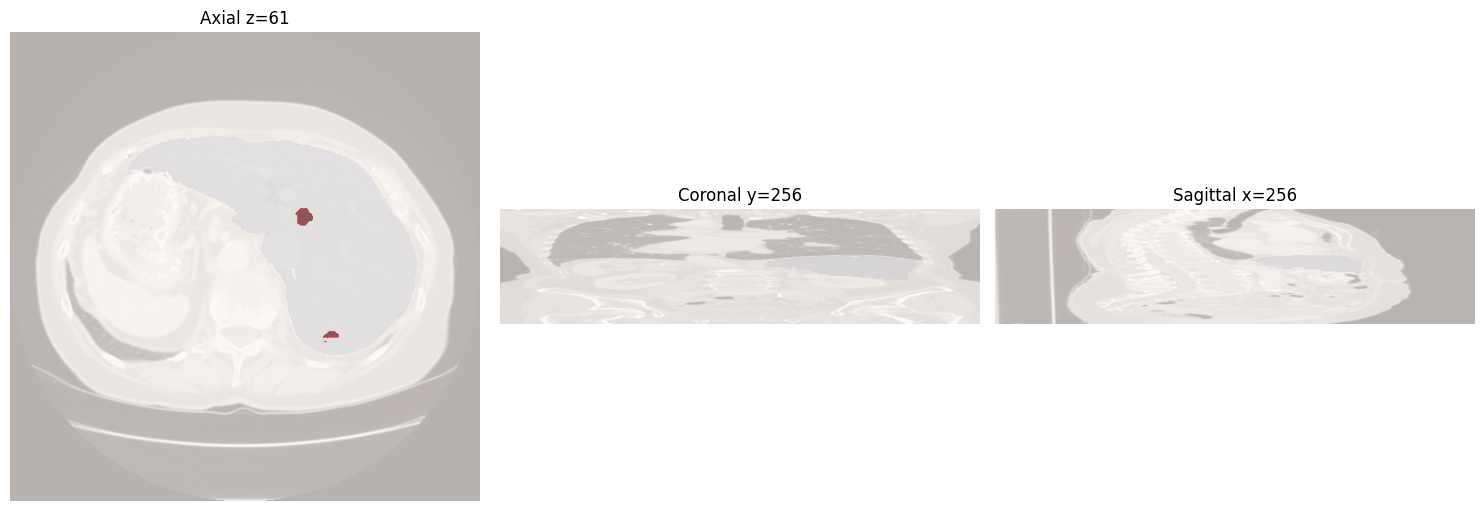

In [9]:
# =============================================================================
# VISUALIZATION
# =============================================================================
import matplotlib.pyplot as plt
import nibabel as nib


def show_slice(ax, sl_img, sl_msk=None, title=""):
    """Display a single slice with optional mask overlay."""
    vmin, vmax = np.percentile(sl_img, [1, 99])
    ax.imshow(np.rot90(sl_img), cmap="gray", vmin=vmin, vmax=vmax)
    
    if sl_msk is not None:
        ax.imshow(np.rot90((sl_msk == 1).astype(np.uint8)), alpha=0.25, cmap="Blues")
        ax.imshow(np.rot90((sl_msk == 2).astype(np.uint8)), alpha=0.65, cmap="Reds")
    
    ax.set_title(title)
    ax.axis("off")


def visualize_sample(img_path: Path, msk_path= None):
    """Visualize axial, coronal, and sagittal slices."""
    img = nib.load(str(img_path)).get_fdata()
    msk = nib.load(str(msk_path)).get_fdata().astype(np.int32) if msk_path else None
    
    z, y, x = img.shape[2] // 2, img.shape[1] // 2, img.shape[0] // 2
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    show_slice(axs[0], img[:, :, z], msk[:, :, z] if msk is not None else None, f"Axial z={z}")
    show_slice(axs[1], img[:, y, :], msk[:, y, :] if msk is not None else None, f"Coronal y={y}")
    show_slice(axs[2], img[x, :, :], msk[x, :, :] if msk is not None else None, f"Sagittal x={x}")
    plt.tight_layout()
    plt.show()


# Example:
visualize_sample(list_nii(IMAGES_TR)[1], LABELS_TR / list_nii(IMAGES_TR)[1].name)